<a href="https://colab.research.google.com/github/Abdul-Moeed/headline-gen-metrics/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2
This notebook goes through the process from generating headlines to evaluating them with GPT-2

## Generate Headlines
In this section, we generate headlines for a Amazon Product Review Dataset.

### Preparing environment

In [0]:
# import google drive access
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
cd /content/gdrive/'My Drive'/GPT-2

/content/gdrive/My Drive/GPT-2


In [0]:
# Load the code
# !git clone https://github.com/DeepOzean/gpt2.git

Cloning into 'gpt2'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 75 (delta 31), reused 62 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [0]:
cd gpt2

/content/gdrive/My Drive/GPT-2/gpt2


In [0]:
!pip install -r requirements.txt

In [0]:
# Downloading a pretrained model
!python download_model.py 117M

In [0]:
import json
import gzip
import math
import numpy as np
import pandas as pd
from utils import getDF
from pickle import load

### Preprocessing
Here we will load the data and use different preprocessing steps - filtering out short headlines and balancing the sentiment.

More subdatasets can be found here: http://jmcauley.ucsd.edu/data/amazon/


In [0]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Patio_Lawn_and_Garden_5.json.gz
#!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz

--2019-09-25 09:25:06--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Patio_Lawn_and_Garden_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954506 (4.7M) [application/x-gzip]
Saving to: ‘reviews_Patio_Lawn_and_Garden_5.json.gz.1’

reviews_Patio_Lawn_ 100%[===================>]   4.72M  1.36MB/s    in 3.5s    

2019-09-25 09:25:10 (1.36 MB/s) - ‘reviews_Patio_Lawn_and_Garden_5.json.gz.1’ saved [4954506/4954506]



In [0]:
# Load Data in a Pandas Dataframe
df = getDF('reviews_Patio_Lawn_and_Garden_5.json.gz')
df = df[['reviewText','summary','overall']]

In [0]:
""" UNCOMMENT FOR CNN/DAILYMAIL
df_cnn = stories = load(open('cnn_formatted.pkl', 'rb'))
df_dailymail = stories = load(open('dailymail_formatted.pkl', 'rb'))
df = pd.concat([df_cnn, df_dailymail], ignore_index=True)
"""

In [0]:
# read newsroom data
# df = load(open('newsroom_formatted.pkl', 'rb'))


In [0]:
# read gigaword data
# df = load(open('gigaword_formatted.pkl', 'rb'))

In [0]:
""" UNCOMMENT FOR CNN/DAILYMAIL
# sample only 15% of data (total size is too big - 180K stories)
df = df.sample(frac=0.15)
df = df.reset_index(drop=True)
df.shape
"""

In [0]:
df.columns = ['story', 'headline', 'overall']
df.head()

,story,headline,overall
0,Good USA company that stands behind their prod...,Great Hoses,4.0
1,This is a high quality 8 ply hose. I have had ...,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,5.0
2,It's probably one of the best hoses I've ever ...,Very satisfied!,4.0
3,I probably should have bought something a bit ...,Very high quality,5.0
4,I bought three of these 5/8-inch Flexogen hose...,Good Hoses,5.0


In [0]:
# Split dataset in train and test
train_test_split = 0.9
n = len(df)
n_train = int(np.floor(n*train_test_split))

df_train = df[:n_train]
df_test = df[n_train+1:]

In [0]:
# Filter out samples with short headlines (>20)
df_train_length_filtered = df_train[df_train['headline'].str.len() > 20]

In [0]:
"""
# Sentiment balancing
df_train_positive = df_train[df_train.overall > 3]
df_train_negative = df_train[df_train.overall <= 3]
n_negative = len(df_train_negative)
df_train_sentiment = df_train_positive[:n_negative]
df_train_sentiment = df_train_sentiment.append(df_train_negative)
"""

In [0]:
# Load reviewText and headlines with different preprocessing into seperate dataframes
df_reviewText_train = df_train['story']
df_reviewText_train_length = df_train_length_filtered['story']
#df_reviewText_train_sentiment = df_train_sentiment['story']
df_reviewText_test = df_test['story']

df_summary_train = df_train['headline']
df_summary_train_length = df_train_length_filtered['headline']
#df_summary_train_sentiment = df_train_sentiment['headline']
df_summary_test = df_test['headline']

In [0]:
# Add TL;DR and [End] Token
corpus = ''
for i in range(len(df_summary_train)):
  corpus += df_reviewText_train[i]
  corpus += ' TL;DR: '
  corpus += df_summary_train[i]
  corpus += ' [End] '
  corpus += '\n'

# Save dataset as txt
with open('story_and_headline.txt', 'w') as f:
  f.write(corpus)
  
# Byte Pair Encoding of Corpus  
!python3 encode.py story_and_headline.txt story_and_headline.txt.npz

Reading files
100% 1/1 [00:14<00:00, 14.48s/it]
Writing story_and_headline.txt.npz


In [0]:
corpus_length = ''
for reviewText, summary in zip(df_reviewText_train_length, df_summary_train_length):
  corpus_length += reviewText
  corpus_length += ' TL;DR: '
  corpus_length += summary
  corpus_length += ' [End] '
  corpus_length += '\n'

with open('story_and_headline_length.txt', 'w') as f:
  f.write(corpus_length)
  
!python3 encode.py story_and_headline_length.txt story_and_headline_length.txt.npz

Reading files
100% 1/1 [00:10<00:00, 10.23s/it]
Writing story_and_headline_length.txt.npz


In [0]:
"""
corpus_sentiment = ''
for reviewText, summary in zip(df_reviewText_train_sentiment, df_summary_train_sentiment):
  corpus_sentiment += reviewText
  corpus_sentiment += ' TL;DR: '
  corpus_sentiment += summary
  corpus_sentiment += ' [End] '
  corpus_sentiment += '\n'

with open('review_and_summary_sentiment.txt', 'w') as f:
  f.write(corpus_sentiment)
  
!python3 encode.py review_and_summary_sentiment.txt review_and_summary_sentiment.txt.npz
"""

In [0]:
corpus_test = ''
for review in df_reviewText_test:
  corpus_test += review
  corpus_test += ' TL;DR:\n'

with open('story_test.txt', 'w') as f:
  f.write(corpus_test)

In [0]:
summary_test = ''
for summary in df_summary_test:
  summary_test += summary
  summary_test += '\n'

with open('headline_test.txt', 'w') as f:
  f.write(summary_test)

### Training

Here we will train the model. We used 5000 runs (--stop_after) and a learning rate of 0.0001 (--learning_rate)

By default, this code trains on the untouched dataset. To change it to a preprocessed one, you can change it using the switch --dataset. Options for it:
- "review_and_summary.txt.npz" (untouched)
- "review_and_summary_length.txt.npz" (length balanced)
- "review_and_summary_sentiment.txt.npz" (sentiment balanced)

In [0]:
!python3 train.py --dataset story_and_headline.txt.npz --sample_every=1000 --learning_rate=0.0001 --stop_after=5000 --run_name 117M --model_name 117M





2019-09-25 09:34:20.730408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-09-25 09:34:20.732482: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x22452c0 executing computations on platform Host. Devices:
2019-09-25 09:34:20.732518: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-25 09:34:20.764346: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-09-25 09:34:20.905680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-25 09:34:20.906596: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2245480 executing computations on platform CUDA. Devices:
2019-09-25 09:34:20.906627: I tensorflow/compiler/xla/service/service.cc:175]   StreamE

In [0]:
# Copy over the trained weights into the correct directory
!cp -r checkpoint/117M/* models/117M/

### Test

Here you can generate samples using the trained models. Some of the switches:
- "--json_name" name the json file with saved samples
- "--top_k" a hyperparameter to control the "randomness" while generating samples, high values are more probabilistic
- "--temperature" another hyperparameter to control the "randomness", high values are more probabilistic
- "--length" number of tokens to generate per sample, the samples are automatically cut off, when [End] is generated, so higher value usually don't increase the length in practice. Higher values  increase computation time
- "--nsamples" number of headlines generated per sample, higher number increase computation time
- "--silent" set to 1 for silent mode (doesn't print the samples, as Google Colab cannot handle too much output well). Samples will still be saved into the json file

In [0]:
!python3 src/interactive_conditional_samples_read_file.py --reviewText story_test.txt --model_name 117M --summaries headline_test.txt \
--json_name 'samples' --top_k 40 --temperature 1.0 --length 40 --nsamples 1 --silent 1



2019-09-25 11:13:02.318592: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-09-25 11:13:02.375508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1005] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-25 11:13:02.376379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1640] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2019-09-25 11:13:02.384666: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.0
2019-09-25 11:13:02.582476: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcublas.so.10.0
2019-09-25 11:13:02.683533: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcufft.so.

In [0]:
# Download Sample
#from google.colab import files
#files.download('samples.json')

## Evaluation
In this part we will evaluate our generated summaries with two different metrics - Angular Embedding Similarity and Frechet Embedding Distance. The details can be found in our paper.

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import json
from utils import create_list, angular_similarity, frechet_distance

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
# Load Data
with open('samples.json', 'r') as read_file:
  data = json.load(read_file)
  
generated, summary, review = create_list(data)

In [0]:

generated = [] # generated
summary = [] # ground truth
review = []

for key in data:
  summary_text = data[key]['summary'][:-1].strip()
  generated_text = data[key]['generated'][0].strip()
  
  if summary_text != generated_text:
    review.append(data[key]['reviewText'][:-7])
    summary.append(summary_text)
    generated.append(generated_text)
  else:
    print(summary_text, " | ", generated_text)


In [0]:
generated = generated[:20]
summary = summary[:20]
review = review[:20]

In [0]:
generated[0], summary[0], review[:20]

### Universal Sentence Encoder

For both metrics, first an embeddings needs to be created. This section sets up the environment for access to the Universal Sentence Encoder on TF Hub. You can choose between two different USE models. We used the normal model, though the larger model may result in better predictions.

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [0]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.FATAL)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Embed data
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  summary_embeddings = session.run(
      similarity_message_encodings, feed_dict={similarity_input_placeholder: summary})
  generated_embeddings = session.run(
      similarity_message_encodings, feed_dict={similarity_input_placeholder: generated})
  review_embeddings = session.run(
      similarity_message_encodings, feed_dict={similarity_input_placeholder: review})

### Angular Similarity

In [0]:
# individual angular similarity calculation
ang_sim_gen_gt = []
ang_sim_gen_text = []
ang_sim_gt_text = []
for i in range(len(generated)):
  gen = np.expand_dims(generated_embeddings[i], axis=0)
  summary = np.expand_dims(summary_embeddings[i], axis=0)
  review = np.expand_dims(review_embeddings[i], axis=0)
  
  ang_sim_gen_gt.append(float(angular_similarity(gen, summary)[0]))
  ang_sim_gen_text.append(float(angular_similarity(gen, review)[0]))
  ang_sim_gt_text.append(float(angular_similarity(summary, review)[0]))

In [0]:
# save these to json file
"""
scores = {}
scores['Newsroom'] = {'gen_gt': ang_sim_gen_gt,
                   'gen_text': ang_sim_gen_text,
                   'gt_text': ang_sim_gt_text}
with open('angular.json', 'a') as outfile:
  json.dump(scores, outfile)
"""

In [0]:
angular_generated_summary = angular_similarity(generated_embeddings, summary_embeddings)
angular_generated_review = angular_similarity(generated_embeddings, review_embeddings)
angular_summary_review = angular_similarity(summary_embeddings, review_embeddings)

0.6903917


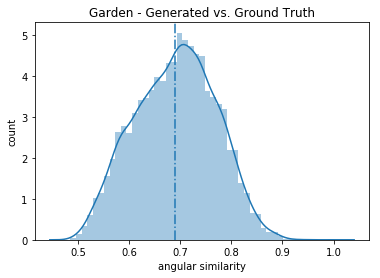

In [0]:
print(angular_generated_summary.mean())
sns.distplot(angular_generated_summary)
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Generated vs. Ground Truth')
plt.axvline(angular_generated_summary.mean(),linestyle='-.')

0.70064783


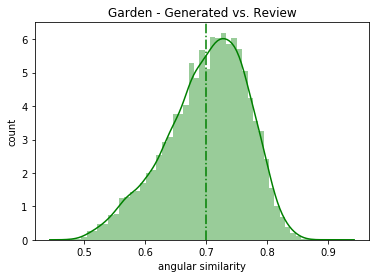

In [0]:
print(angular_generated_review.mean())
sns.distplot(angular_generated_review,color='g')
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Generated vs. Review')
plt.axvline(angular_generated_review.mean(),linestyle='-.',color='g')

0.7161089


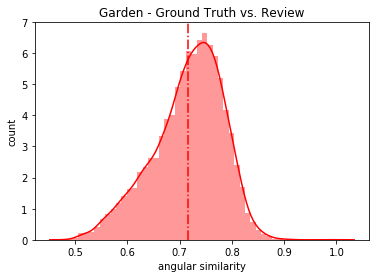

In [0]:
print(angular_summary_review.mean())
sns.distplot(angular_summary_review,color='r')
plt.xlabel('angular similarity')
plt.ylabel('count')
plt.title('Garden - Ground Truth vs. Review')
plt.axvline(angular_summary_review.mean(),linestyle='-.',color='r')

### Frechet Distance

In [0]:
print('FED - generated vs. reference headline: ',frechet_distance(generated_embeddings,summary_embeddings))
print('FED - generated vs. reference review text: ',frechet_distance(generated_embeddings,review_embeddings))
print('FED - reference headline vs. reference review text: ',frechet_distance(summary_embeddings,review_embeddings))

FED - generated vs. reference headline:  0.044406544
FED - generated vs. reference review text:  0.54242826
FED - reference headline vs. reference review text:  0.54108006
